In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SBSSBSBB'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [2]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [3]:
from pyspark import SparkContext
# sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [4]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [5]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1451.5| 42.0358|-111.9617|       SNWD|USC00109698|    43|[00 00 00 00 00 0...|2007.0|SBSSBSBB|
|   1473.1|   41.15|-111.9167|       SNWD|USC00428885|     0|[F4 5D C0 5E C0 5...|1949.0|SBSSBSBB|
|   1473.1|   41.15|-111.9167|       SNWD|USC00428885|     0|[90 5D 58 5E C0 5...|1950.0|SBSSBSBB|
|   1473.1|   41.15|-111.9167|       SNWD|USC00428885|     1|[C0 54 60 52 C0 5...|1951.0|SBSSBSBB|
|   1473.1|   41.15|-111.9167|       SNWD|USC00428885|     0|[58 5A 58 5A 58 5...|1952.0|SBSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

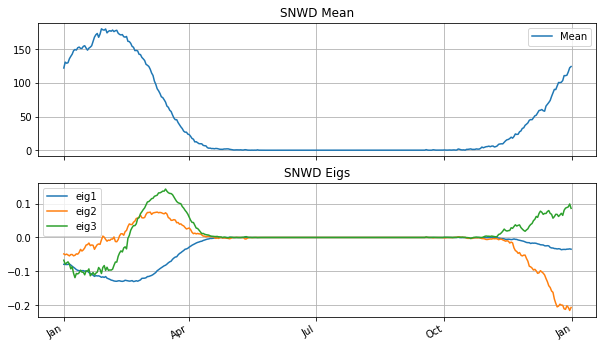

In [6]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [7]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

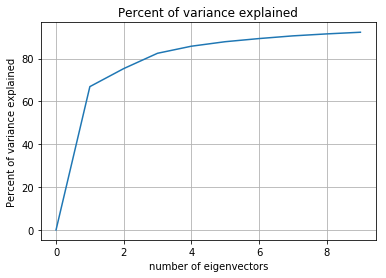

In [8]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [9]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [10]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1236
after filter 710


In [11]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [168]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
#             print i,j
            row=rows[k]
            k+=1
#             _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
#                     %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
#             _title = 'c1 = %3.2f, r1 = %3.2f'%(row['coeff_1'],row['res_1'])
#             print j,_title,axes.shape
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [169]:
df4=df3.filter(df3.res_1<0.4).sort(df3.coeff_1)
rows=df4.take(12)
df4.select('coeff_1','res_1').show(4)

+------------------+-------------------+
|           coeff_1|              res_1|
+------------------+-------------------+
|-8120.978919346245|0.05356989831297677|
|-7420.680114501645|0.07091683476758551|
|-5732.606852332282|0.06105810475599986|
|-5646.479802178427|0.12820619997653696|
+------------------+-------------------+
only showing top 4 rows



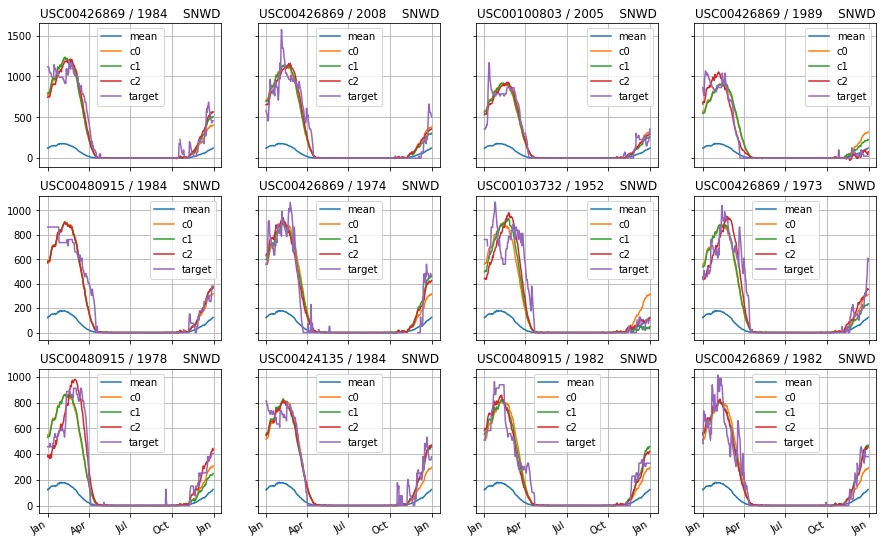

In [170]:
plot_recon_grid(rows)

In [171]:
df3.sort?

In [172]:
df5=df3.filter(df3.res_1<0.4).sort(df3.coeff_1,ascending=False)
rows=df5.take(12)
df5.select('coeff_1','res_1').show(4)

+-----------------+------------------+
|          coeff_1|             res_1|
+-----------------+------------------+
|779.0655473048615| 0.339241200695125|
|757.5367693166357|0.3585780270683978|
|674.7968964068501|0.3736377493560642|
|657.3882723480648|0.3285550063643551|
+-----------------+------------------+
only showing top 4 rows



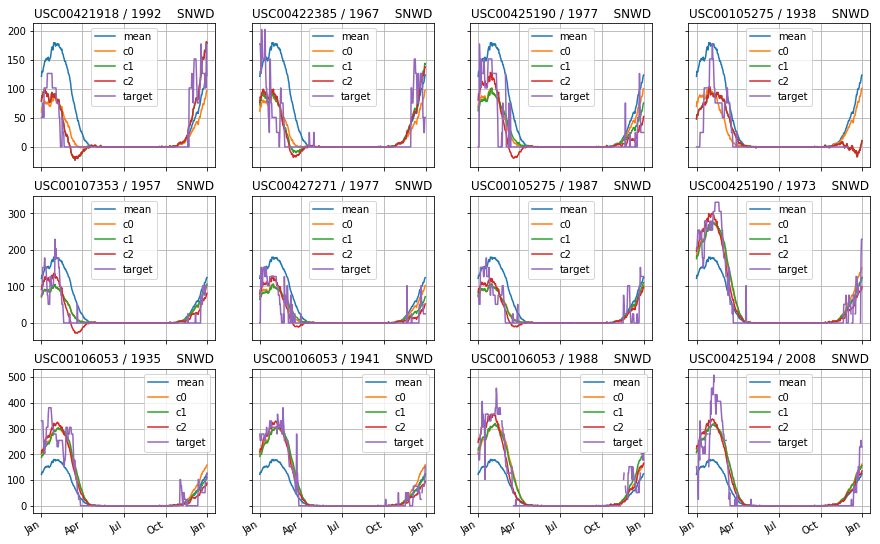

In [173]:
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.533962488258
residual normalized norm  after mean + top eigs: [ 0.34428354  0.34413796  0.02117816]


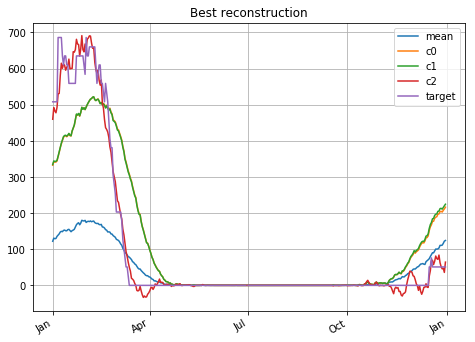

In [14]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [150]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
#     print P
#     vals=[vals[0]]+vals
    plot(vals,P*100)
    title('cumulative distribution of '+feat)
    ylabel('percentage of instances')
    xlabel(feat)
    grid()

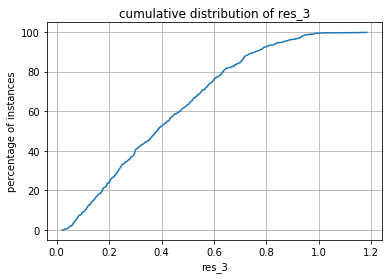

In [155]:
plot_CDF('res_3')

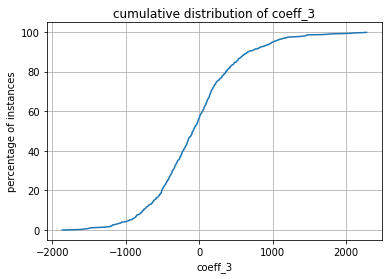

In [156]:
plot_CDF('coeff_3')

In [47]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [48]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.6M	../../Data/Weather/US_Weather_SBSSBSBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
3.9M	../../Data/Weather/decon_BBBSBBBB_PRCP.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SBSSBSBB_PRCP.parquet
2.3M	../../Data/Weather/decon_SBSSBSBB_SNWD.parquet


In [9]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
print rows[0][:2]

days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector
    
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

(u'USC00109698', 2007.0)


In [10]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00421601 365
USC00480915 11524
USC00426404 19652
USC00426405 726
USC00420487 2672
USC00107353 7660
USC00428885 3585
USC00425182 11096
USC00106053 19623
USC00425186 24678
USW00024120 8508
USC00426938 5878
USC00424135 9637
USC00103732 10718
USC00428828 9271
USC00420924 8098
USW00024126 1458
USC00424970 685
USC00421222 326
USC00420928 6868
USW00024101 8006
USC00421731 16346
USC00424856 17528
USC00427271 27265
US1UTCH0002 332
USC00426414 9122
USC00427318 15306
USC00425826 8960
USC00426869 19410
US1UTDV0020 674
USC00107346 3911
USC00429346 13050
USC00105275 27751
USC00422385 19812
USC00421918 8228
USC00425190 6632
USC00109698 322
USC00425194 13378
USC00423671 3150
USC00421590 6453
USC00100803 5703
USC00429595 8265
USC00422721 1756
USC00427165 6036
USC00425082 14122
USC00422726 12706


In [13]:
Stations=sorted(All.keys())
print Stations
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

[u'US1UTCH0002', u'US1UTDV0020', u'USC00100803', u'USC00103732', u'USC00105275', u'USC00106053', u'USC00107346', u'USC00107353', u'USC00109698', u'USC00420487', u'USC00420924', u'USC00420928', u'USC00421222', u'USC00421590', u'USC00421601', u'USC00421731', u'USC00421918', u'USC00422385', u'USC00422721', u'USC00422726', u'USC00423671', u'USC00424135', u'USC00424856', u'USC00424970', u'USC00425082', u'USC00425182', u'USC00425186', u'USC00425190', u'USC00425194', u'USC00425826', u'USC00426404', u'USC00426405', u'USC00426414', u'USC00426869', u'USC00426938', u'USC00427165', u'USC00427271', u'USC00427318', u'USC00428828', u'USC00428885', u'USC00429346', u'USC00429595', u'USC00480915', u'USW00024101', u'USW00024120', u'USW00024126']
(46, 40515)


In [21]:
mean_by_station=np.nanmean(day_station_table,axis=1)
std_by_station=np.nanstd(day_station_table,axis=1)
# print zip(Stations,mean_by_station,std_by_station)
# print std_by_station
print mean_by_station

[   5.47289157   13.90801187  122.5865334    45.74864714   41.95596555
   70.61142537   27.57427768   32.34060052   10.58074534   49.3008982
   17.16028649   18.2866919     0.           58.76228111   50.11780822
   23.28049676   37.88551288   31.43317182   22.88211845   25.13135527
   45.33492063   76.94770157   39.22837745    4.69927007   37.38273616
   18.49594448   25.20726963   31.79704463   34.25586784   18.6359375
   18.2789538    14.72176309    4.98487174  113.25332303    3.39231031
   37.84542744   32.38694297   18.43603815   36.51936145   41.23654114
   36.42819923   26.43859649   95.52724748   26.6324007    26.61941702
   30.23799726]


In [19]:
from pickle import dump
with open(data_dir+'/SNWD_mean.pickle','wb') as file:
    dump({'stations':Stations,
          'mean':mean_by_station,
          'std':std_by_station},
        file)